<a href="https://colab.research.google.com/github/FatmaBuseBorlu/KDEF/blob/main/KDEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli Kütüphaneler
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Veri İndirme (KDEF Kaggle üzerinden)
path = kagglehub.dataset_download("tom99763/testtt")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tom99763/testtt/versions/1


In [ ]:
dataset_dir = "/root/.cache/kagglehub/datasets/tom99763/testtt/versions/1"
print("Dataset directories:", os.listdir(dataset_dir))

Dataset directories: ['happy', 'disgust', 'neutral', 'angry', 'sad', 'fear', 'surprise']


In [ ]:
# Veri seti yolu
dataset_dir = "/root/.cache/kagglehub/datasets/tom99763/testtt/versions/1"
categories = ['disgust', 'angry', 'surprise', 'happy', 'neutral', 'sad', 'fear']
img_size = (48, 48)

In [ ]:
# Veri yükleme (daha büyük boyut için)
def load_data_high_res(dataset_dir, categories, img_size=(96, 96)):
    data = []
    labels = []
    data_color = []  # Renkli görüntüler için ayrı bir liste

    for label_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Gri ölçekli görüntü
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_gray = cv2.resize(img_gray, img_size) / 255.0

            # Renkli görüntü
            img_color = cv2.imread(img_path)
            img_color = cv2.resize(img_color, img_size)

            data.append(img_gray)
            data_color.append(img_color)
            labels.append(label_idx)

    data = np.array(data).reshape(-1, img_size[0], img_size[1], 1)
    data_color = np.array(data_color)
    labels = np.array(labels)
    return data, data_color, labels

# Veri setini yükleyin
data, data_color, labels = load_data_high_res(dataset_dir, categories)

# Eğitim ve test verilerine bölme
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
X_train_color, X_test_color, _, _ = train_test_split(data_color, labels, test_size=0.2, stratify=labels, random_state=42)

# One-hot encoding
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

print(f"Eğitim veri sayısı: {X_train.shape[0]}")
print(f"Test veri sayısı: {X_test.shape[0]}")

Eğitim veri sayısı: 2350
Test veri sayısı: 588


In [ ]:
# Sad sınıfını tekrar dengeleme
sad_data = [(X_train[i], y_train[i]) for i in range(len(y_train)) if np.argmax(y_train[i]) == categories.index('sad')]
other_data = [(X_train[i], y_train[i]) for i in range(len(y_train)) if np.argmax(y_train[i]) != categories.index('sad')]

# Sad sınıfını çoğalt
sad_data_upsampled = resample(sad_data, replace=True, n_samples=len(other_data) // len(categories), random_state=42)

# Yeni eğitim setini birleştir
balanced_data = other_data + sad_data_upsampled
X_train_balanced, y_train_balanced = zip(*balanced_data)
X_train = np.array(X_train_balanced)
y_train = np.array(y_train_balanced)

In [ ]:
# Model Tanımı
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [ ]:
# Modeli derle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 94, 94, 64)        640       
                                                                 
 max_pooling2d_97 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_130 (Dropout)       (None, 47, 47, 64)        0         
                                                                 
 conv2d_98 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_98 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_131 (Dropout)       (None, 22, 22, 128)     

In [ ]:
class_weights = {
    0: 1.0,  # Disgust
    1: 1.0,  # Angry
    2: 1.0,  # Surprise
    3: 1.0,  # Happy
    4: 1.0,  # Neutral
    5: 2.0,  # Sad (ağırlığı artırıldı)
    6: 1.0   # Fear
}

In [ ]:
# Modeli eğitim sırasında çağrı fonksiyonuyla eğitin
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
72/72 [==============================] - 14s 174ms/step - loss: 2.2142 - accuracy: 0.1329 - val_loss: 1.9510 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 12s 167ms/step - loss: 2.1701 - accuracy: 0.1273 - val_loss: 1.9358 - val_accuracy: 0.1446 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 12s 165ms/step - loss: 2.0511 - accuracy: 0.2189 - val_loss: 1.6423 - val_accuracy: 0.3707 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 12s 166ms/step - loss: 1.7487 - accuracy: 0.3853 - val_loss: 1.4055 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 12s 167ms/step - loss: 1.4329 - accuracy: 0.5130 - val_loss: 1.1509 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 12s 168ms/step - loss: 1.2863 - accuracy: 0.5613 - val_loss: 1.0565 - val_accuracy: 0.5816 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 12s 167ms/st

In [ ]:
# Test Verileri Üzerinde Performans
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Kayıp: {test_loss:.4f}")
print(f"Test Doğruluk: {test_acc:.4f}")

19/19 [==============================] - 1s 30ms/step - loss: 0.6688 - accuracy: 0.7925
Test Kayıp: 0.6688
Test Doğruluk: 0.7925


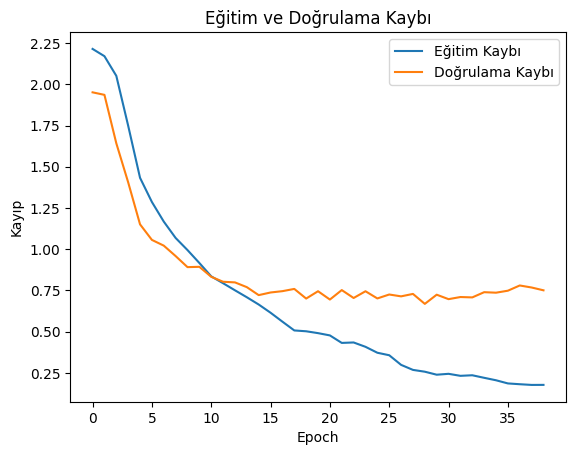

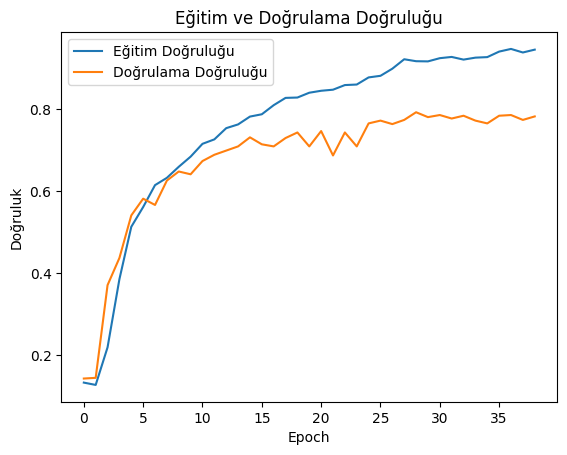

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı grafiği
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğu grafiği
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

19/19 [==============================] - 1s 29ms/step


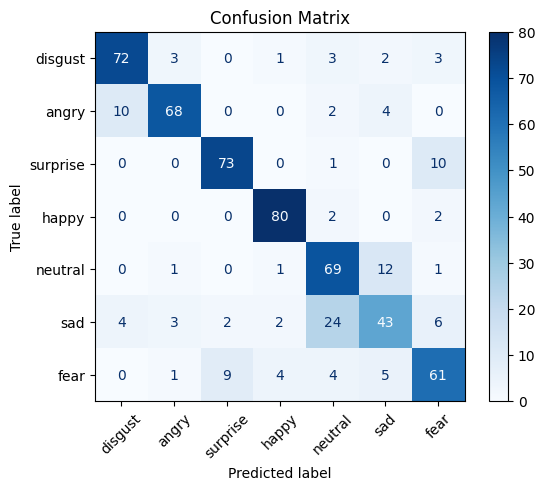

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, X_test, y_test, categories):
    # Tahmin yap
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)  # Tahmin edilen sınıflar
    y_true = np.argmax(y_test, axis=1)  # Gerçek sınıflar

    # Confusion Matrix'i oluştur
    cm = confusion_matrix(y_true, y_pred, labels=range(len(categories)))

    # Confusion Matrix'i görselleştir
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Confusion Matrix'i test verilerinde göster
plot_confusion_matrix(model, X_test, y_test, categories)


19/19 [==============================] - 1s 30ms/step
Gerçek Duygu: surprise
Tahmin Edilen Duygu: surprise


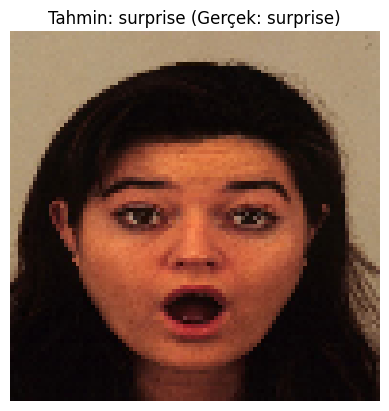

Gerçek Duygu: disgust
Tahmin Edilen Duygu: disgust


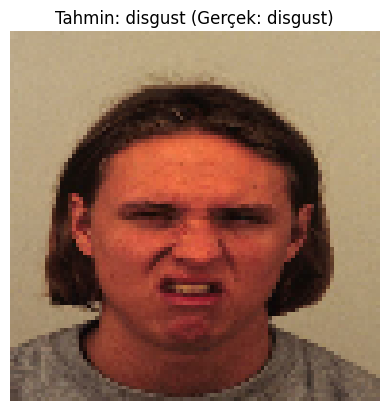

Gerçek Duygu: surprise
Tahmin Edilen Duygu: surprise


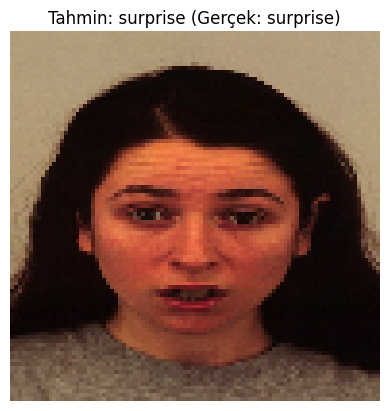

Gerçek Duygu: fear
Tahmin Edilen Duygu: fear


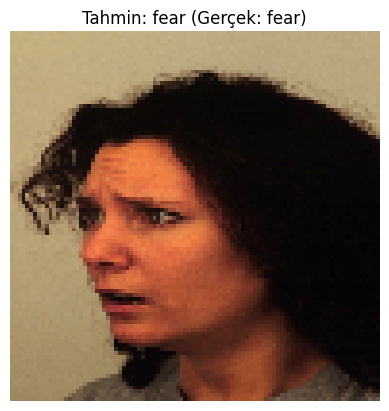

Gerçek Duygu: disgust
Tahmin Edilen Duygu: disgust


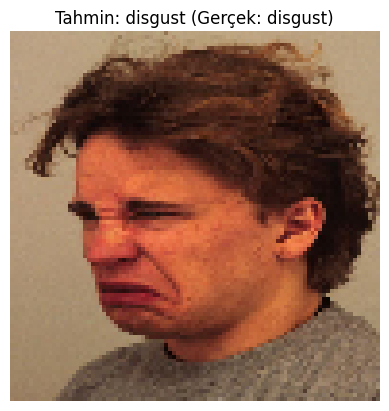

Gerçek Duygu: disgust
Tahmin Edilen Duygu: disgust


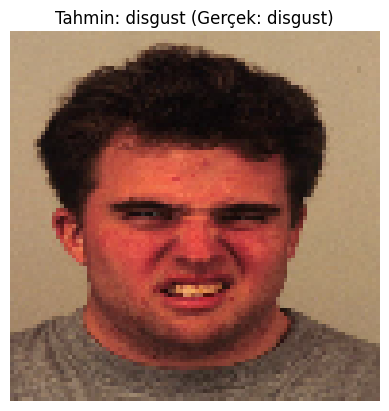

Gerçek Duygu: neutral
Tahmin Edilen Duygu: neutral


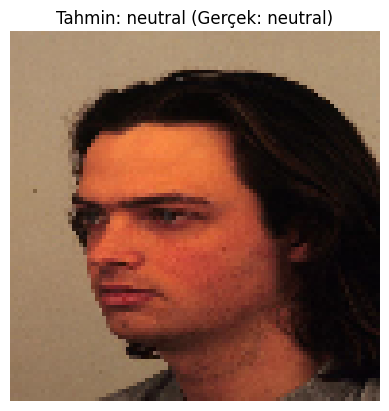

Gerçek Duygu: neutral
Tahmin Edilen Duygu: neutral


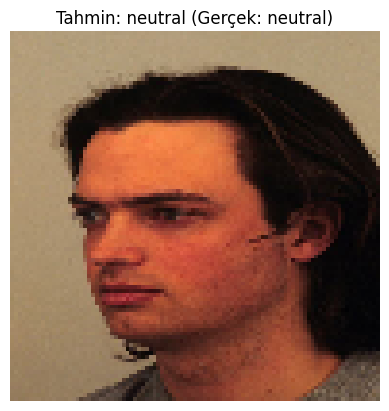

Gerçek Duygu: surprise
Tahmin Edilen Duygu: neutral


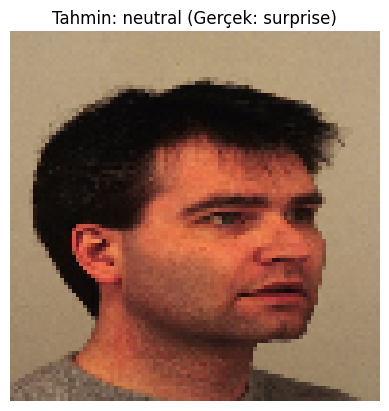

Gerçek Duygu: neutral
Tahmin Edilen Duygu: neutral


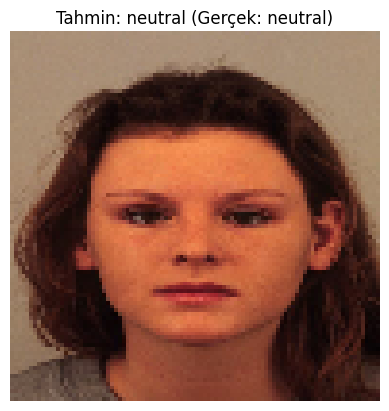

In [ ]:
# Test verisinden tahmin yapma (Yüksek çözünürlük ve renkli)
def test_predictions_with_high_res(model, X_test, y_test, X_test_color, categories):
    predictions = model.predict(X_test)
    for i in range(10):  # İlk 10 görüntüdeki tahminleri göster
        print(f"Gerçek Duygu: {categories[np.argmax(y_test[i])]}")
        print(f"Tahmin Edilen Duygu: {categories[np.argmax(predictions[i])]}")

        # Renkli görüntüyü yüksek çözünürlükte görselleştir
        plt.imshow(cv2.cvtColor(X_test_color[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Tahmin: {categories[np.argmax(predictions[i])]} (Gerçek: {categories[np.argmax(y_test[i])]})")
        plt.axis('off')
        plt.show()

# Tahminleri test edin
test_predictions_with_high_res(model, X_test, y_test, X_test_color, categories)

In [ ]:
# Modeli Keras formatında kaydet
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.savefig("docs/confusion_matrix.png")  # 📌 Burası önemli
plt.show()

model.save("emotion_recognition_model.keras")